In [1]:
!wget http://images.cocodataset.org/zips/train2017.zip -q --show-progress
!wget https://s3-us-west-2.amazonaws.com/dl.fbaipublicfiles.com/LVIS/lvis_v1_train.json.zip -q --show-progress

!unzip -qq "./train2017.zip" -d "./train"
!unzip -qq "./lvis_v1_train.json.zip" -d "./labels"
!pip install -q lvis

train2017.zip       100%[===================>]  18.01G  30.8MB/s    in 17m 47s 
lvis_v1_train.json. 100%[===================>] 334.04M  5.96MB/s    in 59s     


In [2]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from PIL import Image
from lvis import LVIS
import cv2

from engine import evaluate, train_one_epoch

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.device(device)


device(type='cuda')

In [3]:
lvis_api = LVIS(
    "labels/lvis_v1_train.json"
)  # колаб крашится если попробовать сделать json.load


In [4]:
def get_helmet_dataset_dicts(lvis_api):
    img_ids = sorted(lvis_api.imgs.keys())
    imgs = lvis_api.load_imgs(img_ids)
    anns = [lvis_api.img_ann_map[img_id] for img_id in img_ids]
    
    def get_file_name(img_root, img_dict):
        split_folder, file_name = img_dict["coco_url"].split("/")[-2:]
        return os.path.join(img_root + split_folder, file_name)

    dataset_dicts = []

    for (img_dict, anno_dict_list) in zip(imgs, anns):
        record = {}
        record["file_name"] = get_file_name("train/", img_dict)
        record["height"] = img_dict["height"]
        record["width"] = img_dict["width"]
        record["image_id"] = img_dict["id"]
        objs = []
        has_helmet = False
        for anno in anno_dict_list:
            # helmet & football_helmet, больше ничего с подстрокой helmet нет
            if anno["category_id"] == 556 or anno["category_id"] == 467:
                objs.append(anno["bbox"])
                has_helmet = True
        record["bbox"] = objs
        if has_helmet:
            dataset_dicts.append(record)
            has_helmet = False
    return dataset_dicts


In [5]:
dataset_dicts = get_helmet_dataset_dicts(lvis_api)


In [6]:
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[..., ::-1])
    else:
        plt.imshow(image)
    plt.axis("off")
    plt.show()


def visualize_from_dataset(file, bboxes):
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    # h, w = img.shape[:2]
    for i in range(len(bboxes)):
        x, y, w, h = bboxes[i]
        x_min, y_min, x_max, y_max = x, y, x + w, y + h
        image = cv2.rectangle(
            img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2
        )
    show_image(image)


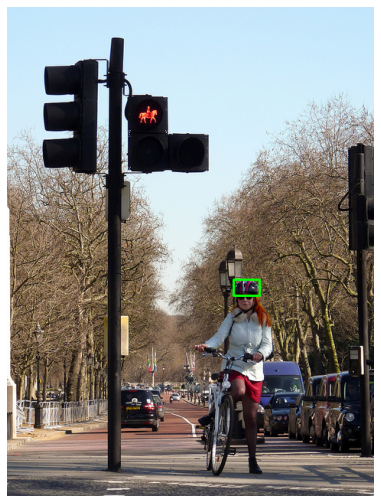

In [7]:
visualize_from_dataset(dataset_dicts[777]["file_name"], dataset_dicts[777]["bbox"])


# Обучение модели FasterRCNN и YOLOv5 для детекции Helmet


In [8]:
class HelmetsDataset(Dataset):
    def __init__(self, dataset_dicts, transforms=None):
        self.dataset_dicts = dataset_dicts
        self.transforms = transforms

    def __getitem__(self, idx):
        data = self.dataset_dicts[idx]
        img_path = data["file_name"]
        img = Image.open(img_path)
        img = np.array(img) / 255
        if len(img.shape) == 2:  # from grayscale to 3 channels
            img = np.stack((img,) * 3, axis=-1)
        img = np.moveaxis(img, 2, 0)  # to [C, H, W]
        n_bboxes = len(data["bbox"])
        bboxes = []
        for i in range(n_bboxes):
            bbox = data["bbox"][i]
            x, y, w, h = bbox
            x_min, y_min, x_max, y_max = x, y, x + w, y + h
            bboxes.append([x_min, y_min, x_max, y_max])

        img = torch.as_tensor(img, dtype=torch.float32)
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)

        labels = torch.ones((n_bboxes,), dtype=torch.int64)
        is_crowd = torch.zeros((n_bboxes,), dtype=torch.int64)

        image_id = torch.tensor([idx])

        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])

        target = {}
        target["boxes"] = bboxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = is_crowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.dataset_dicts)


-   Используем dataset LVIS [link](https://www.lvisdataset.org/)


-   [Репозиторий YOLOv5](https://github.com/ultralytics/yolov5)


-   [Конфигурационный файл](https://github.com/ultralytics/yolov5/blob/master/data/coco128.yaml)


In [9]:
train_dataset_dicts, val_dataset_dicts = train_test_split(dataset_dicts, test_size=0.1)


In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [11]:
train_dataset = HelmetsDataset(train_dataset_dicts)
val_dataset = HelmetsDataset(val_dataset_dicts)

train_loader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, drop_last=True
)
val_loader = DataLoader(
    val_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, drop_last=True
)


In [12]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=True, pretrained_backbone=True
)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight en

  0%|          | 0.00/160M [00:00<?, ?B/s]

In [13]:
num_classes = 2
in_channels = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(
    in_channels=in_channels, num_classes=num_classes
)


In [14]:
model.to(device)
# сначала прогоним 1 эпоху для предобученной сетки, чтобы она лучше поняла что есть шлемы

# затем зафризим и дообучим только предиктор
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.roi_heads.box_predictor.parameters():
#     param.requires_grad = True

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)


In [15]:
num_epochs = 1
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=400)

    evaluate(model, val_loader, device=device)
    torch.save(model.state_dict(), "test_model_state_dict_last.pth")


Epoch: [0]  [  0/429]  eta: 1:05:16  lr: 0.000017  loss: 1.1237 (1.1237)  loss_classifier: 0.9170 (0.9170)  loss_box_reg: 0.0285 (0.0285)  loss_objectness: 0.1687 (0.1687)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 9.1302  data: 0.0952  max mem: 4765
Epoch: [0]  [400/429]  eta: 0:00:41  lr: 0.004685  loss: 0.3165 (0.3515)  loss_classifier: 0.0935 (0.1209)  loss_box_reg: 0.1341 (0.1426)  loss_objectness: 0.0233 (0.0433)  loss_rpn_box_reg: 0.0423 (0.0447)  time: 1.5319  data: 0.0468  max mem: 7549
Epoch: [0]  [428/429]  eta: 0:00:01  lr: 0.005000  loss: 0.2324 (0.3459)  loss_classifier: 0.0791 (0.1186)  loss_box_reg: 0.1117 (0.1413)  loss_objectness: 0.0191 (0.0421)  loss_rpn_box_reg: 0.0093 (0.0438)  time: 1.5097  data: 0.0476  max mem: 7549
Epoch: [0] Total time: 0:10:21 (1.4492 s / it)
creating index...
index created!
Test:  [ 0/47]  eta: 0:00:30  model_time: 0.5997 (0.5997)  evaluator_time: 0.0126 (0.0126)  time: 0.6529  data: 0.0365  max mem: 7549
Test:  [46/47]  eta: 0:00:00  model_

In [16]:
for param in model.parameters():
    param.requires_grad = False
for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=400)

    evaluate(model, val_loader, device=device)
    torch.save(model.state_dict(), "test_model_state_dict_last.pth")


Epoch: [0]  [  0/429]  eta: 0:03:46  lr: 0.000017  loss: 0.1731 (0.1731)  loss_classifier: 0.0576 (0.0576)  loss_box_reg: 0.0711 (0.0711)  loss_objectness: 0.0384 (0.0384)  loss_rpn_box_reg: 0.0061 (0.0061)  time: 0.5281  data: 0.0425  max mem: 7549
Epoch: [0]  [400/429]  eta: 0:00:19  lr: 0.004685  loss: 0.2331 (0.2375)  loss_classifier: 0.0580 (0.0732)  loss_box_reg: 0.1072 (0.1133)  loss_objectness: 0.0194 (0.0217)  loss_rpn_box_reg: 0.0157 (0.0293)  time: 0.6636  data: 0.0370  max mem: 7549
Epoch: [0]  [428/429]  eta: 0:00:00  lr: 0.005000  loss: 0.1766 (0.2370)  loss_classifier: 0.0542 (0.0727)  loss_box_reg: 0.0797 (0.1125)  loss_objectness: 0.0158 (0.0218)  loss_rpn_box_reg: 0.0107 (0.0300)  time: 0.6604  data: 0.0361  max mem: 7549
Epoch: [0] Total time: 0:04:46 (0.6668 s / it)
creating index...
index created!
Test:  [ 0/47]  eta: 0:00:29  model_time: 0.5824 (0.5824)  evaluator_time: 0.0051 (0.0051)  time: 0.6225  data: 0.0314  max mem: 7549
Test:  [46/47]  eta: 0:00:00  model_

In [17]:
torch.save(model, "model_final.pth")


In [18]:
model = torch.load("model_final.pth")


In [19]:
def visualize_prediction_helmet(
    file, model, device="cuda", verbose=True, thresh=0.0, n_colors=None, id_to_name=None
):
    img = Image.open(file)
    img = np.array(img) / 255
    if len(img.shape) == 2:  # from grayscale to 3 channels
        img = np.stack((img,) * 3, axis=-1)
    img = np.moveaxis(img, 2, 0)  # to [C, H, W]
    img_tensor = torch.as_tensor(img, dtype=torch.float32)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model(img_tensor.unsqueeze(0).to(device))  # list of size 1
    prediction = predictions[0]

    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features

    palette = sns.color_palette(None, n_colors)

    # visualize
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    image = img
    for i in range(len(prediction["boxes"])):
        x_min, y_min, x_max, y_max = map(int, prediction["boxes"][i].tolist())
        label = int(prediction["labels"][i].cpu())
        score = float(prediction["scores"][i].cpu())
        name = id_to_name[label]
        color = palette[label]
        if verbose:
            if score > thresh:
                print("Class: {}, Confidence: {}".format(name, score))
        if score > thresh:
            image = cv2.rectangle(
                img, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2
            )
            cv2.putText(
                image,
                name,
                (x_min, y_min - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                np.array(color) * 255,
                2,
            )
    show_image(image)
    return prediction


In [31]:
idx = np.random.randint(0, len(val_dataset_dicts))
file_name = val_dataset_dicts[idx]["file_name"]
print(file_name)


train/train2017/000000496575.jpg


Class: helmet, Confidence: 0.9832636713981628
Class: helmet, Confidence: 0.9700366258621216
Class: helmet, Confidence: 0.9643452763557434
Class: helmet, Confidence: 0.962786853313446
Class: helmet, Confidence: 0.9580292105674744
Class: helmet, Confidence: 0.948183000087738
Class: helmet, Confidence: 0.9450153112411499
Class: helmet, Confidence: 0.9434933662414551
Class: helmet, Confidence: 0.9186242818832397
Class: helmet, Confidence: 0.9056380987167358
Class: helmet, Confidence: 0.8812393546104431
Class: helmet, Confidence: 0.8554543852806091
Class: helmet, Confidence: 0.7067094445228577
Class: helmet, Confidence: 0.6473649144172668
Class: helmet, Confidence: 0.5430318713188171


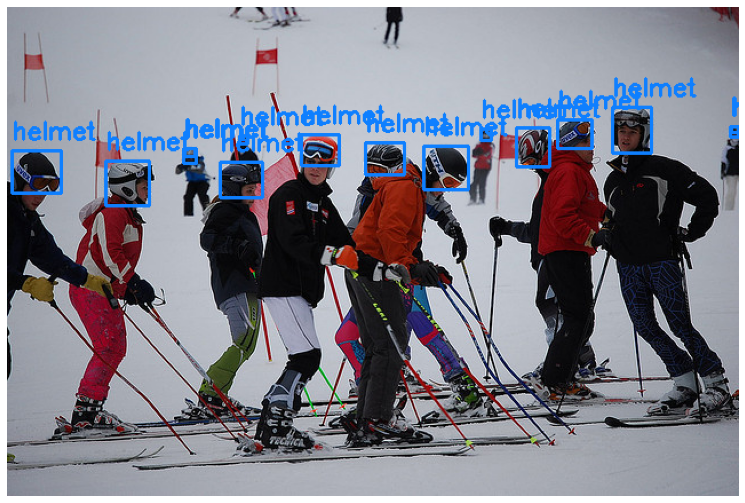

{'boxes': tensor([[364.6505, 122.2289, 403.1493, 160.2098],
         [ 86.9411, 135.3368, 124.0862, 174.7171],
         [529.5615,  88.3850, 563.7682, 128.5830],
         [632.3621, 105.3256, 639.9999, 114.3334],
         [186.3517, 136.5751, 223.0508, 167.9369],
         [154.4759, 124.8446, 165.6854, 137.1410],
         [313.1336, 119.0984, 347.0398, 147.1790],
         [257.0900, 112.0979, 290.5946, 139.6756],
         [481.7844,  99.7046, 511.1751, 124.6877],
         [  4.0624, 126.6262,  47.5697, 163.1486],
         [414.9507, 107.6571, 423.8226, 117.2554],
         [445.3722, 106.8608, 474.8570, 140.5497],
         [155.6600, 124.7620, 164.5958, 131.6237],
         [203.0460, 113.0966, 210.1570, 120.5841],
         [633.1494, 105.1018, 639.6699, 110.1638],
         [115.8452, 138.3589, 129.4122, 151.7732],
         [496.6889, 100.6989, 514.2363, 117.0201],
         [149.6031, 124.6049, 168.7695, 145.1501],
         [481.8808,  99.6238, 501.0524, 115.2589],
         [165.6901, 12

In [32]:
visualize_prediction_helmet(file_name, model, id_to_name={1: "helmet"}, thresh=0.5)
